<a href="https://colab.research.google.com/github/kridtapon/UO-GAP-Trap/blob/main/UO_GAP_Trap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.8 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.59
    Uninstalling yfinance-0.2.59:
      Successfully uninstalled yfinance-0.2.59


In [59]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# --- Ultimate Oscillator ---
def ultimate_oscillator(df, short=7, medium=14, long=28):
    high = df['High']
    low = df['Low']
    close = df['Close']

    TR = pd.concat([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ], axis=1).max(axis=1)

    BP = close - pd.concat([low, close.shift(1)], axis=1).min(axis=1)

    avg7 = BP.rolling(short).sum() / TR.rolling(short).sum()
    avg14 = BP.rolling(medium).sum() / TR.rolling(medium).sum()
    avg28 = BP.rolling(long).sum() / TR.rolling(long).sum()

    UO = 100 * (4 * avg7 + 2 * avg14 + avg28) / (4 + 2 + 1)
    return UO

# --- GAPO (Gopalakrishnan Range Index) ---
def gapo(df, period=14):
    def fractal_dimension(p):
        highest = df['High'].rolling(p).max()
        lowest = df['Low'].rolling(p).min()
        n = (highest - lowest) / df['Close'].rolling(p).mean()
        n = n.replace(0, np.nan)
        return np.log(n) / np.log(p)

    return fractal_dimension(period)

# --- Download data ---
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Calculate indicators ---
df['UO'] = ultimate_oscillator(df)
df['GAPO'] = gapo(df)

# --- GAPO trend direction ---
df['GAPO_Trend'] = df['GAPO'].diff()

# --- Entry & Exit Signals ---
df['Entry'] = (df['UO'] < 40) | (df['GAPO_Trend'] < 0)
df['Exit'] = (df['UO'] > 60) & (df['GAPO_Trend'] > 0)

# --- Filter by test window ---
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# --- Shift to avoid lookahead bias ---
shifted_entries = df['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df['Exit'].shift(1).fillna(False).astype(bool).to_numpy()

# --- Backtest Portfolio ---
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# --- Results ---
print(portfolio.stats())
portfolio.plot().show()



[*********************100%***********************]  1 of 1 completed
<ipython-input-59-de815f3103c3>:59: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-59-de815f3103c3>:60: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                   233250.77498
Total Return [%]                              133.250775
Benchmark Return [%]                           187.56104
Max Gross Exposure [%]                             100.0
Total Fees Paid                             17465.574055
Max Drawdown [%]                               72.655749
Max Drawdown Duration                  590 days 00:00:00
Total Trades                                          68
Total Closed Trades                                   67
Total Open Trades                                      1
Open Trade PnL                             -14306.041497
Win Rate [%]                                   80.597015
Best Trade [%]                                 23.289555
Worst Trade [%]                

In [60]:
# --- Entry & Exit Signals ---
df['Entry'] = (df['UO'] < df['UO'].shift(10)) & (df['GAPO_Trend'] < 0)
df['Exit'] = (df['UO'] > df['UO'].shift(10)) & (df['GAPO_Trend'] > 0)

# --- Filter by test window ---
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# --- Shift to avoid lookahead bias ---
shifted_entries = df['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df['Exit'].shift(1).fillna(False).astype(bool).to_numpy()

# --- Backtest Portfolio ---
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# --- Results ---
print(portfolio.stats())
portfolio.plot().show()

<ipython-input-60-b1073a41e050>:9: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-60-b1073a41e050>:10: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  426301.331685
Total Return [%]                              326.301332
Benchmark Return [%]                           187.56104
Max Gross Exposure [%]                             100.0
Total Fees Paid                             35751.542402
Max Drawdown [%]                               34.586141
Max Drawdown Duration                  349 days 00:00:00
Total Trades                                          74
Total Closed Trades                                   73
Total Open Trades                                      1
Open Trade PnL                             -26146.470647
Win Rate [%]                                   69.863014
Best Trade [%]                                 23.693706
Worst Trade [%]                

In [58]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# --- Ultimate Oscillator ---
def ultimate_oscillator(df, short=7, medium=14, long=28):
    high = df['High']
    low = df['Low']
    close = df['Close']

    TR = pd.concat([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ], axis=1).max(axis=1)

    BP = close - pd.concat([low, close.shift(1)], axis=1).min(axis=1)

    avg7 = BP.rolling(short).sum() / TR.rolling(short).sum()
    avg14 = BP.rolling(medium).sum() / TR.rolling(medium).sum()
    avg28 = BP.rolling(long).sum() / TR.rolling(long).sum()

    UO = 100 * (4 * avg7 + 2 * avg14 + avg28) / (4 + 2 + 1)
    return UO

# --- GAPO (Gopalakrishnan Range Index) ---
def gapo(df, period=14):
    def fractal_dimension(p):
        highest = df['High'].rolling(p).max()
        lowest = df['Low'].rolling(p).min()
        n = (highest - lowest) / df['Close'].rolling(p).mean()
        n = n.replace(0, np.nan)
        return np.log(n) / np.log(p)

    return fractal_dimension(period)

# --- Download data ---
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Calculate indicators ---
df['UO'] = ultimate_oscillator(df)
df['GAPO'] = gapo(df)

# --- GAPO trend direction ---
df['GAPO_Trend'] = df['GAPO'].diff()

# --- Entry & Exit Signals ---
df['Entry'] = (df['UO'] < df['UO'].shift(10)) & (df['GAPO_Trend'] < 0)
df['Exit'] = (df['UO'] > df['UO'].shift(10)) & (df['GAPO_Trend'] > 0)

# --- Filter by test window ---
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# --- Shift to avoid lookahead bias ---
shifted_entries = df['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df['Exit'].shift(1).fillna(False).astype(bool).to_numpy()

# --- Backtest Portfolio ---
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# --- Results ---
print(portfolio.stats())
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-58-b28eee2345db>:59: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-58-b28eee2345db>:60: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  426301.331685
Total Return [%]                              326.301332
Benchmark Return [%]                           187.56104
Max Gross Exposure [%]                             100.0
Total Fees Paid                             35751.542402
Max Drawdown [%]                               34.586141
Max Drawdown Duration                  349 days 00:00:00
Total Trades                                          74
Total Closed Trades                                   73
Total Open Trades                                      1
Open Trade PnL                             -26146.470647
Win Rate [%]                                   69.863014
Best Trade [%]                                 23.693706
Worst Trade [%]                

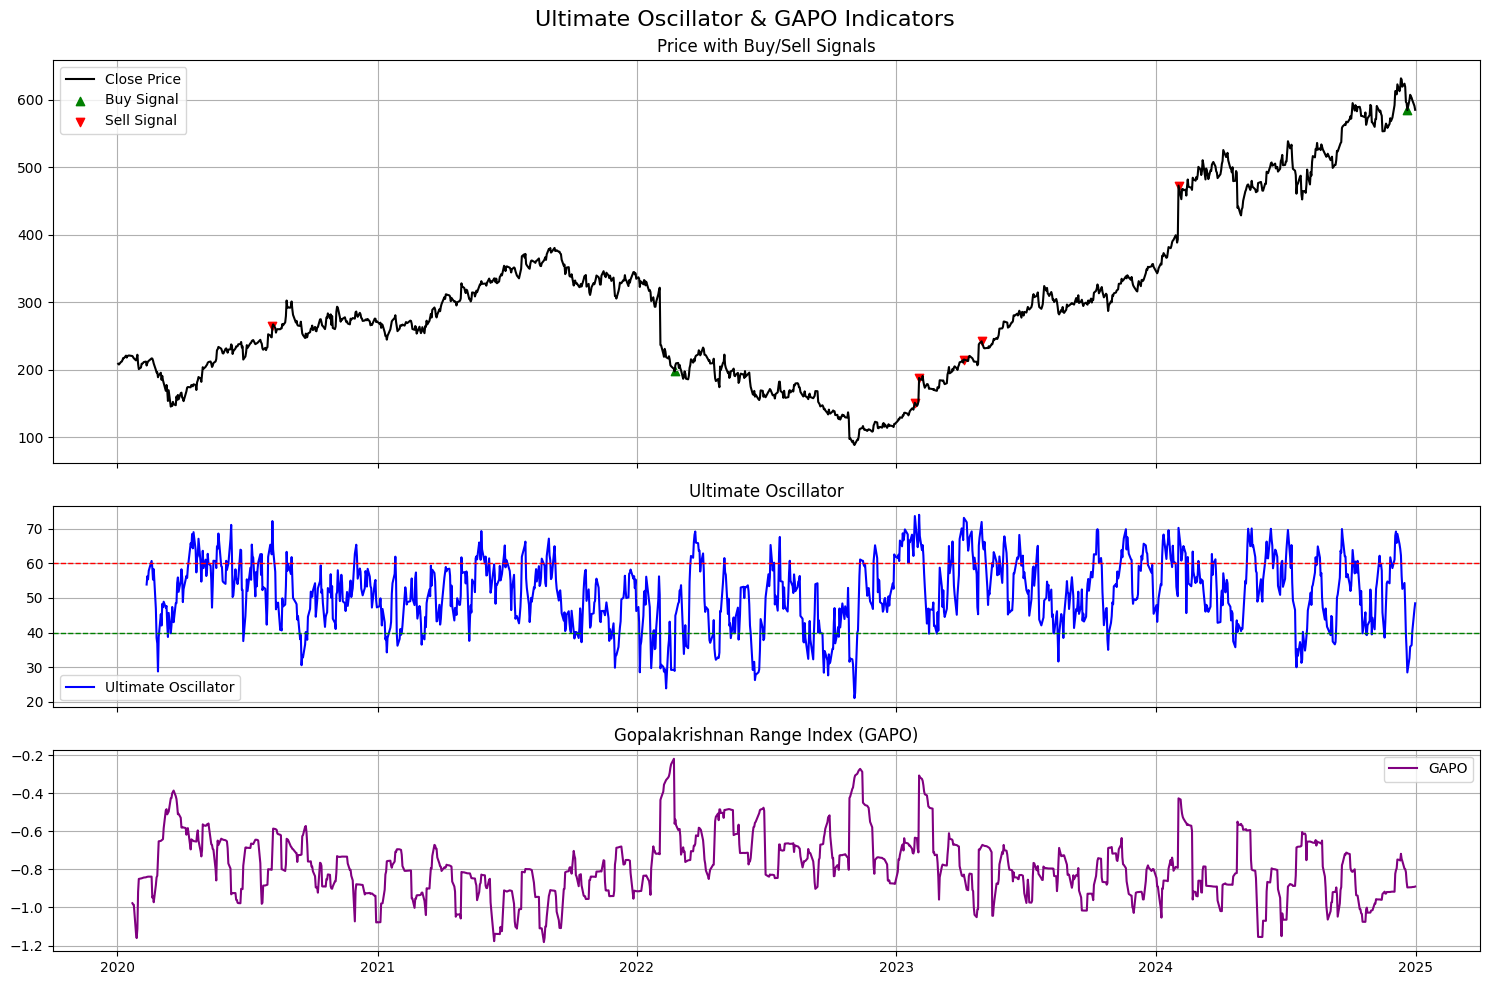

In [64]:
import matplotlib.pyplot as plt

# Ensure indicators are calculated
df['UO'] = ultimate_oscillator(df)
df['GAPO'] = gapo(df)
df['GAPO_Trend'] = df['GAPO'].diff()
df['Entry'] = (df['UO'] < 30) & (df['GAPO_Trend'] < 0)
df['Exit'] = (df['UO'] > 70) & (df['GAPO_Trend'] > 0)

# Plot setup
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
fig.suptitle('Ultimate Oscillator & GAPO Indicators', fontsize=16)

# --- Price chart with signals ---
axs[0].plot(df.index, df['Close'], label='Close Price', color='black')
axs[0].scatter(df[df['Entry']].index, df[df['Entry']]['Close'], marker='^', color='green', label='Buy Signal')
axs[0].scatter(df[df['Exit']].index, df[df['Exit']]['Close'], marker='v', color='red', label='Sell Signal')
axs[0].set_title('Price with Buy/Sell Signals')
axs[0].legend()
axs[0].grid()

# --- Ultimate Oscillator ---
axs[1].plot(df.index, df['UO'], label='Ultimate Oscillator', color='blue')
axs[1].axhline(60, color='red', linestyle='--', linewidth=1)
axs[1].axhline(40, color='green', linestyle='--', linewidth=1)
axs[1].set_title('Ultimate Oscillator')
axs[1].legend()
axs[1].grid()

# --- GAPO ---
axs[2].plot(df.index, df['GAPO'], label='GAPO', color='purple')
axs[2].set_title('Gopalakrishnan Range Index (GAPO)')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
